# Fire Mapping

Welcome to the 2021 Better Working World Data Challenge!
<img align = 'right' src="../Supplementary_data/EY_logo.png" style="margin:0px 50px">
### Task

The training dataset contains 129 linescan images (infra-red images taken from an airplane) of bushfires in Victoria, Australia, during the first three months of 2019. There are also polygons showing where the fire is in each image, which have been hand-drawn by our collaborators at the Country Fire Authority (CFA). These polygons are the ground truth your solution should be able to recreate.

There are an additional 5 linescan images, the test dataset, where the polygons showing the fire boundaries have not been provided. Your task is to train a model or process which can produce a fire boundary for the remaining 5 linescans with no polygon.

All the linescan images (both the traning and test sets) are served via the Open Data Cube python library. The polygons are already available in your environment.



## Installing libraries 

In [1]:
!pip install tensorflow==2.2.0
!pip install keras==2.3.1
!pip install albumentations
!pip install segmentation_models

You should consider upgrading via the '/env/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/env/bin/python3 -m pip install --upgrade pip' command.


You should consider upgrading via the '/env/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/env/bin/python3 -m pip install --upgrade pip' command.


## Import libraries and instantiate a datacube

In [2]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import re
from PIL import Image as im
from datetime import datetime


from datacube import Datacube
import matplotlib.pyplot as plt

from skimage.transform import AffineTransform, warp
from skimage import io, img_as_ubyte
import random
import os
from scipy.ndimage import rotate
import albumentations as A
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
from sklearn.model_selection import train_test_split

sys.path.append("../Fire-mapping/scripts")
from dea_plotting import map_shapefile
from dea_spatialtools import xr_rasterize

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [3]:
dc = Datacube(app="Getting started") #loading data from datacube

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


In [4]:
linescan_datasets = dc.find_datasets(product='linescan')
linescan_datasets = sorted(linescan_datasets, key = lambda ds: (ds.center_time, ds.id))
ds = dc.load(product='linescan', id=linescan_datasets[23].id, output_crs='epsg:28355', resolution=(-10,10))
ds

<xarray.Dataset>
Dimensions:      (time: 1, x: 1171, y: 777)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-25T22:55:00
  * y            (y) float64 5.833e+06 5.833e+06 ... 5.826e+06 5.826e+06
  * x            (x) float64 4.258e+05 4.258e+05 ... 4.375e+05 4.375e+05
    spatial_ref  int32 28355
Data variables:
    linescan     (time, y, x) uint8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           epsg:28355
    grid_mapping:  spatial_ref

The results stored in linescan_datasets are metadata which describe the various linescan files, including the filename (called the 'label'), extent, date and time of acquisition, and an ID number for that dataset. Not until we load the dataset can we actually read or view the data. The cell below loads a single linescan from the available list.

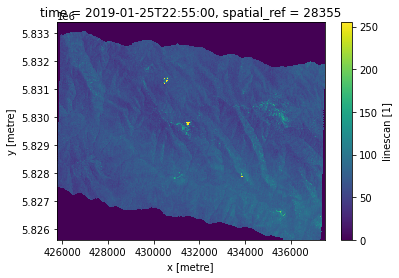

In [5]:
ds.linescan.plot()

In [6]:
train = pd.read_csv('resources/challenge1_train.csv', index_col='id')
train.head(3)

,label,dateTimeLocal,dateTimeUTC
id,,,
0,ROSEDALE_P1_201901041439_MGA94_55,4/01/2019 14:39,4/01/2019 3:39
1,ROSEDALE_1_P1_201901041446_MGA94_55,4/01/2019 14:46,4/01/2019 3:46
2,ROSEDALE_3_P1_201901041501_MGA94_55,4/01/2019 15:01,4/01/2019 4:01


## Import Target Variable: Fire Map Polygons

Let's load and display the dataset.

In [7]:
vector_file = 'resources/fire_boundaries.shp'
gdf = gpd.read_file(vector_file)
gdf.head(3).T

,0,1,2
Source,Linescan,Linescan,Linescan
SourceName,aberfeldy west 200 p1_201901260955_mga94_55.jpg,aberfeldy west 200 p1_201901260955_mga94_55.jpg,aberfeldy west 200 p1_201901260955_mga94_55.jpg
Type,Initial ignition,Initial ignition,Initial ignition
dtString,2019/01/26 09:55:00.000,2019/01/26 09:55:00.000,2019/01/26 09:55:00.000
Comments,originally Latrobe 87 - Jericho - Jim Track,originally Latrobe 86 - Jericho - Thomson - Jo...,originally Latrobe 85 - Jericho - Cream Can Hill
dtUTC,2019-01-25 22:55:00,2019-01-25 22:55:00,2019-01-25 22:55:00
dtLocal,2019-01-26 09:55:00,2019-01-26 09:55:00,2019-01-26 09:55:00
ID,0,1,2
event,Latrobe86,Latrobe86,Latrobe86
geometry,"POLYGON ((431455.6047864075 5829806.836519156,...","POLYGON ((433874.4491466696 5827986.798174933,...","POLYGON ((430459.9135101112 5831285.491971598,..."


In [8]:
attribute_col = 'SourceName'
map_shapefile(gdf, attribute=attribute_col, fillOpacity=0.2, color="yellow", fillColor="red", default_zoom=8)

Label(value='')

Map(center=[-37.61040977368337, 146.4838196608676], controls=(ZoomControl(options=['position', 'zoom_in_text',…

### Cleaning Fire Map Polygon dataset
Ploygon dataset has some common polygon for few images

#### Composite Polygons

Another subset of the polygon dataset that will require more careful consideration are polygons derived from multiple linescans. These polygons usually represent larger fires that stretch over many linescan images and are referred to as "composite polygons".

Identifying these polygons is a little trickier and involves searching the SourceName attribute for the word "composite". Some composites might not meet this condition, but will have a list of numbers representing the linescans it was derived from, so in addition to "composite", we will also search for commas and the ampersand symbol '&'

In [9]:
def clean_name(name):
    if name is None:
        res = None
    else:
        if name.upper()[-4::] == ".JPG":
            res = name.upper()[:-4].replace(' ','_')
        else:
            res = name.upper().replace(' ','_')
    return res

gdf['SourceNameClean'] = gdf.apply(lambda row: clean_name(row.SourceName), axis=1)
gdf.dtUTC = gdf.apply(lambda row: datetime.strptime(row.dtUTC, '%Y-%m-%d %H:%M:%S'), axis=1)
gdf.dtLocal = gdf.apply(lambda row: datetime.strptime(row.dtLocal, '%Y-%m-%d %H:%M:%S'), axis=1)

In [10]:
#taking all row in which sourcename doesn't belong to train sourcename
composites = gdf[gdf.SourceName.str.upper().str.contains(",|&|(COMPOSITE)", na=False)]
composites.SourceName.unique()

/env/lib/python3.6/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


array(['Composite wallhalla 397,398 & 401 20190225 (1311 to 1342hrs)',
       'macalister 681 & 682, (684 & 685 minor) composite 0517-0539hrs',
       'composite macalister97 803, 806 &  807 1455-1532hrs',
       'macalister91 751, 752, 755, 760, 761 & 762 composite 1549-1730hrs',
       'macalister91 766,767 & 770 composite 1239-1314hrs',
       'macalister91 775, 776, 779 & 783 composite 1345-1643hrs',
       'macalister91 789, 790 & 793 composite 1330-1358hrs',
       'macalister91 804, 805 & 808 composite 1503-1539hrs',
       'macalister91 646,648 & 649 composite - 0440hrs to 0453hrs',
       'macalister 695,698 & 699 composite 1542 - 1610hrs',
       'macalister 696,697,700 - 1545-1613hrs',
       'Composite wallhalla 380 & 381 20190206 (1347 & 1356hrs)'],
      dtype=object)

As we can see that these composite polygons are shared in more than one linescan images. So, we will duplicate these polygon for these linescan images.

In [11]:
gdf_composites = gdf[gdf.SourceName.str.upper().str.contains(",|&|(COMPOSITE)", na=False)]

def get_fire_id(name):
    s=re.split(' |,|_|\*|\n|\\(|\\)',name)
    ID=[]
    for i in s:
        r=re.match('\d\d\d$',i)
        if r:
            ID.append(i)
    return ID

#getting all fire ids from sourcename (including composites)
gdf_composites['Fire_ID'] = gdf_composites.apply(lambda row: get_fire_id(row.SourceName), axis=1)
gdf_composites=gdf_composites.explode('Fire_ID')

/env/lib/python3.6/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [12]:
train = gpd.read_file('resources/challenge1_train.csv', index_col='id')

#getting all fire ids from labels in train dataset
train['Fire_ID'] = train.apply(lambda row: get_fire_id(row.label), axis=1)
train=train.explode('Fire_ID')

/env/lib/python3.6/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [13]:
#merging train fire ids with polygon data fire ids
newdf=gdf_composites.merge(train,on='Fire_ID',how='inner')
gdf.drop(list(composites.index), axis = 0,inplace=True)
newdf.rename(
  columns={
    'geometry_x' : 'geometry',
  },
  inplace=True
)
newdf.drop(['geometry_y','dateTimeUTC','dateTimeLocal','id','Fire_ID'], axis = 1,inplace=True)
gdf['label'] = gdf['SourceNameClean']

In [14]:
gdf1=gdf.append(newdf, ignore_index = True)

In [15]:
#merging train label with ploygon sourcename (renamed as label) to get label for corresponding fire ids.
gdf1=gdf1.merge(train,on='label',how='inner')
gdf1.rename(
  columns={
    'geometry_x' : 'geometry',
  },
  inplace=True
)
gdf1.drop(['geometry_y','id','Fire_ID'], axis = 1,inplace=True)

gdf = gpd.GeoDataFrame(gdf1)
gdf.crs = "EPSG:28355"

#### Summary of the challenging aspects of the polygon dataset
As pointed out in the sections above, there is a subset of polygons that will need more careful consideration if they are to be matched to their relevant linescans. In this guide, we will not attempt to match composite polygons as this process is more involved and is part of the challenge!

For contestants that wish to attempt the matching of this set of polygons, it is worth noting that the timestamps on these polygons were manually entered and hence may be prone to inaccuracies. Any matching technique that might involve the timestamp should consider this and perhaps look at applying a time buffer either side, the size of which is a hyperparameter. The larger the time buffer, the more polygons will be matched, but at the risk of matching polygons that are sourced from linescans at a later or earlier time. This means there is a trade-off between the completeness of the matching annotations that are identified, and annotation noise.

In addition to the potential for slight errors, the timestamp of composite polygons are ambiguous by nature, so the time range contained within the SourceName (given in local time) should be preferred to the timestamp given in the dtLocal variable.

## Compare linescan against target polygon

In [16]:
fname = linescan_datasets[23].metadata_doc['label']
ob = gdf.loc[gdf.SourceNameClean == fname]
src = dc.load(product='linescan', id=linescan_datasets[23].id, output_crs='epsg:28355', resolution=(-10,10))

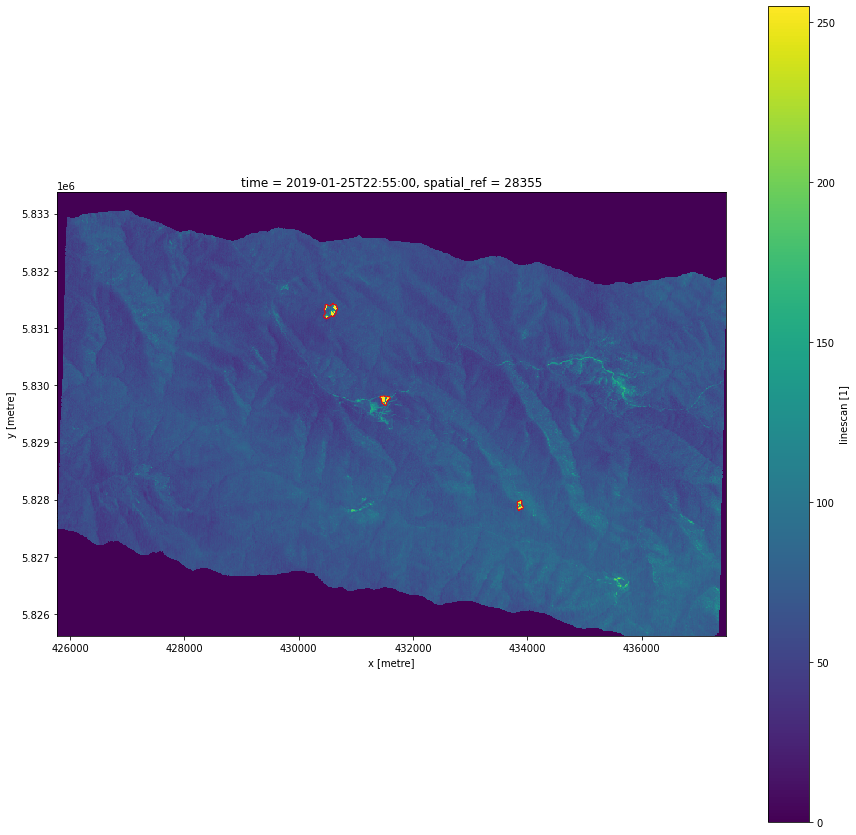

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
src.linescan.plot(ax=ax)
ob.geometry.exterior.plot(ax=ax, edgecolor='red', linewidths=1)

Currently, our polygons are made from vertices and paths. This is called vector data. By comparison, our linescans are grids of pixel values, called raster data. It may be useful to convert the polygons into a binary raster called a "mask", as many machine learning libraries accept masks as input rather than polygons. We can use the src variable to define the extent of the mask that is created from any polygons that intersect with it.

In [18]:
tgt = xr_rasterize(gdf=ob, da=src)

Rasterizing to match xarray.DataArray dimensions (777, 1171)


Text(0.5, 1.0, 'Target: ground truth mask')

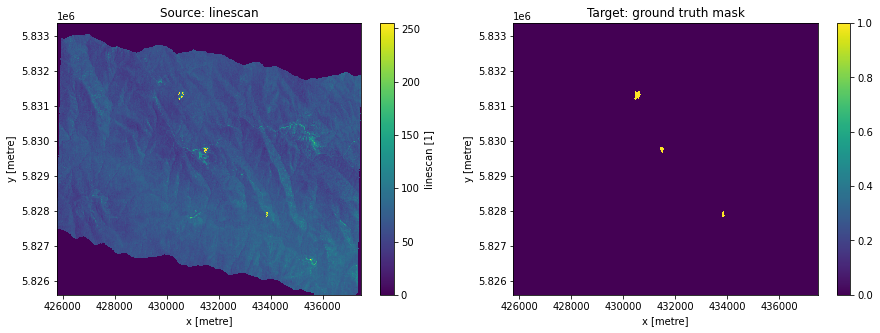

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
src.linescan.plot(ax=ax[0])
ax[0].set_title('Source: linescan')

tgt.plot(ax=ax[1])
ax[1].set_title('Target: ground truth mask')

## Saving linescan images and corresponding masks

In [20]:
train = pd.read_csv('resources/challenge1_train.csv', index_col='id')
image_names = []
for l in train.label:
    ob = gdf.loc[gdf.label == l]
    if not ob.empty:
        src = dc.load(product='linescan', label=l, output_crs='epsg:28355', resolution=(-10,10))
        img = np.array(src.linescan[0])
        
        tgt = xr_rasterize(gdf=ob, da=src)
        tgt = np.array(tgt)
        tgt = (tgt * 255).astype(np.uint8)

        mask = im.fromarray(tgt)
        mask = mask.convert("RGB")
        save_dir = 'data/train_masks'
        mask.save(f'{save_dir}/{l}.jpeg')
        
    
        img = im.fromarray(img)
        img = img.convert("RGB")
        save_dir = 'data/train_images'
        img.save(f'{save_dir}/{l}.jpeg')
        
        image_names.append(l)

Rasterizing to match xarray.DataArray dimensions (777, 1171)
Rasterizing to match xarray.DataArray dimensions (1297, 3333)
Rasterizing to match xarray.DataArray dimensions (1873, 2125)
Rasterizing to match xarray.DataArray dimensions (2052, 2196)
Rasterizing to match xarray.DataArray dimensions (2022, 2435)
Rasterizing to match xarray.DataArray dimensions (2295, 1799)
Rasterizing to match xarray.DataArray dimensions (1908, 2142)
Rasterizing to match xarray.DataArray dimensions (1963, 2224)
Rasterizing to match xarray.DataArray dimensions (1753, 1934)
Rasterizing to match xarray.DataArray dimensions (3314, 1683)
Rasterizing to match xarray.DataArray dimensions (2440, 2132)
Rasterizing to match xarray.DataArray dimensions (2847, 2720)
Rasterizing to match xarray.DataArray dimensions (2792, 2645)
Rasterizing to match xarray.DataArray dimensions (2818, 2951)
Rasterizing to match xarray.DataArray dimensions (2461, 2380)
Rasterizing to match xarray.DataArray dimensions (2580, 2399)
Rasterizi

In [21]:
print("Total Images saved with polygons",len(image_names))

Total Images saved with polygons 69


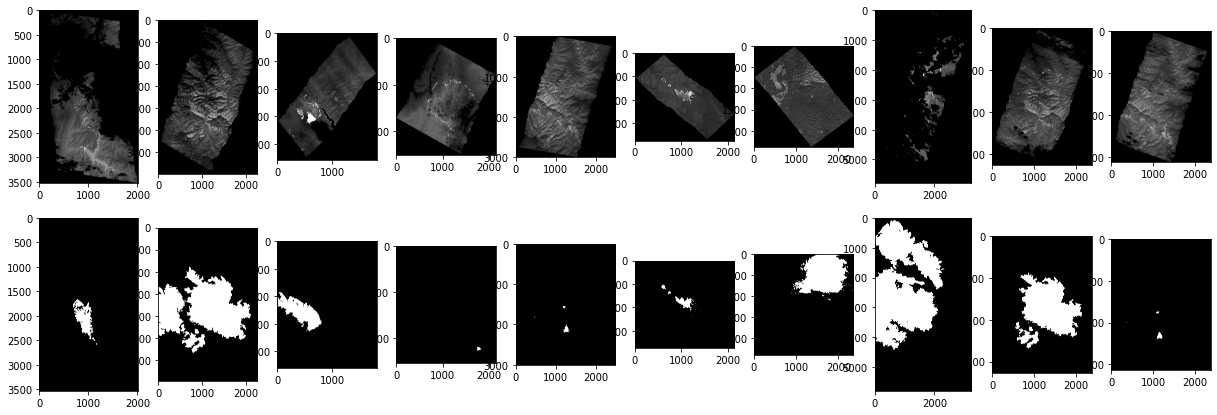

In [22]:
#Checking if images are mapped correctly
fig,ax = plt.subplots(nrows=2, ncols=10, figsize=(21,7))
for i in range(10):
    j = random.randint(0,68)
    name = image_names[j]
    img = cv2.imread("data/train_images/"+name+".jpeg")
    mask = cv2.imread("data/train_masks/"+name+".jpeg")
    ax[0][i].imshow(img)
    ax[1][i].imshow(mask)

Dataset is very small and also with variable image dimensions.

## Generating data using augmentation 

Generating 200 images of dimension (1024x1024) from these 69 images

In [23]:
from augmentation import *
X,Y = image_generate(200,1024,1024) #image_generate take 3 arguments (no. of images, width, height)

## Preparing model

Model: Unet with resnet34 backbone  (https://arxiv.org/abs/1505.04597)
![2.png](https://raw.githubusercontent.com/qubvel/segmentation_models/master/images/unet.png)

In [24]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

X = np.array(X)
Y = np.array(Y)

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=42)
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

In [25]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, None, None, 3 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_1[0][0]           
____________________________________________________________________________________________

Train on 180 samples, validate on 20 samples
Epoch 1/5
180/180 [==============================] - 908s 5s/step - loss: -0.1469 - mse: 7.9551 - val_loss: -128263.8500 - val_mse: 6.9792
Epoch 2/5
180/180 [==============================] - 884s 5s/step - loss: -0.9326 - mse: 7.8956 - val_loss: -724.8358 - val_mse: 6.9793
Epoch 3/5
180/180 [==============================] - 884s 5s/step - loss: -1.9130 - mse: 7.8848 - val_loss: -2461202.8375 - val_mse: 6.9792
Epoch 4/5
180/180 [==============================] - 885s 5s/step - loss: -3.0898 - mse: 7.8808 - val_loss: -4144.7495 - val_mse: 6.9792
Epoch 5/5
180/180 [==============================] - 885s 5s/step - loss: -4.7329 - mse: 7.8821 - val_loss: -1.1519 - val_mse: 6.9797


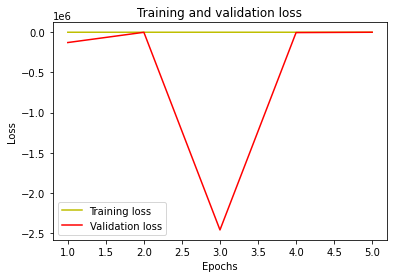

In [26]:
history=model.fit(x_train, 
          y_train,
          batch_size=4, 
          epochs=5,
          verbose=1,
          validation_data=(x_val, y_val))

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
model.save('models/1024_5_n.h5')

## Prediction

### Saving test images

In [28]:
test = pd.read_csv('resources/challenge1_test.csv', index_col='id')
fnames = test.label.unique()

In [29]:
for f in fnames:
    src = dc.load(product='linescan', label=f, output_crs='epsg:28355', resolution=(-10,10))
    img = np.array(src.linescan[0])
    
    img = im.fromarray(img)
    img = img.convert("RGB")
    save_dir = 'data/test_images'
    img.save(f'{save_dir}/{f}.jpeg')

### Loading model

In [30]:
from tensorflow import keras
model = keras.models.load_model('models/1024_5.h5', compile=False)

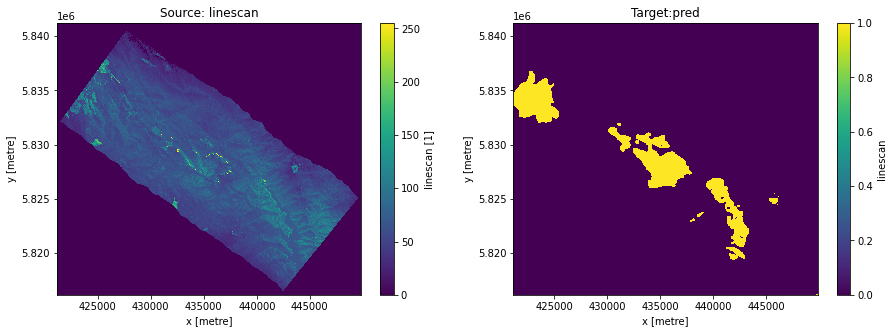

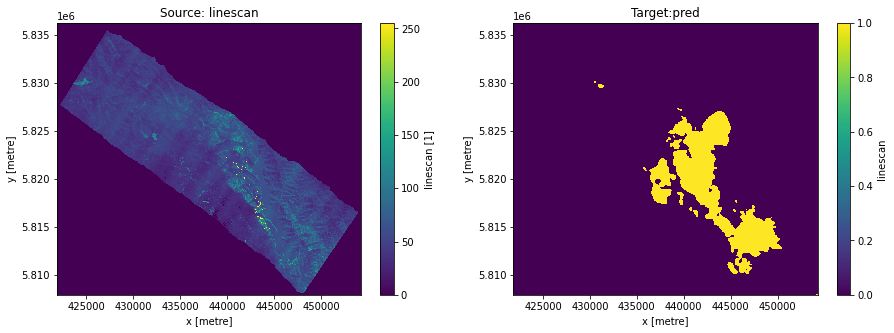

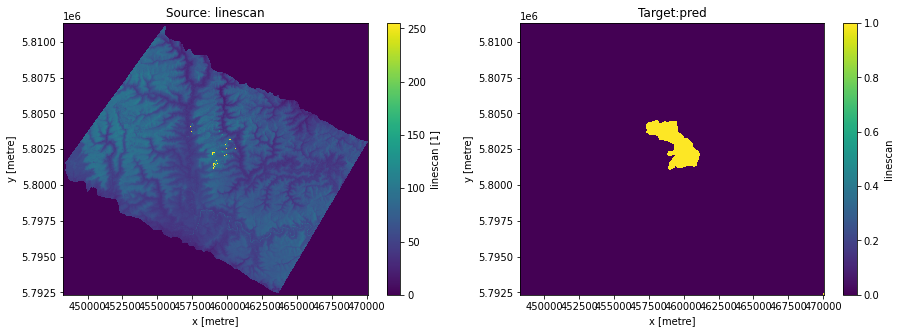

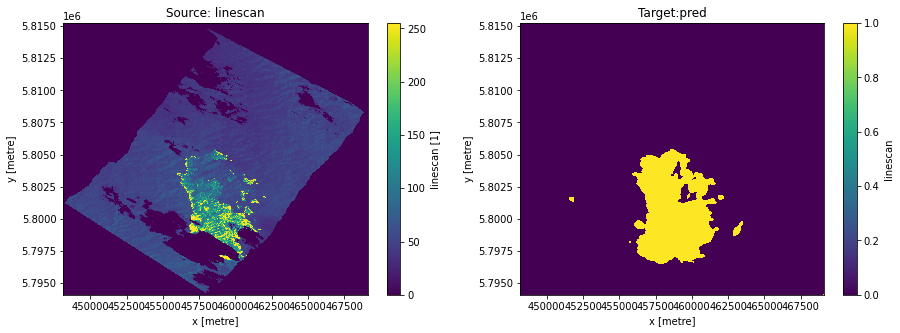

In [ ]:
test = pd.read_csv('resources/challenge1_test.csv', index_col='id')
fnames = test.label.unique()
for f in fnames:
    src = dc.load(product='linescan', label=f, output_crs='epsg:28355', resolution=(-10,10))
    filename = f+'.jpeg'
    img = cv2.imread('data/test_images/' + filename, cv2.IMREAD_COLOR)
    x,y,_ = img.shape
    img = cv2.resize(img,(512,512))
    img = np.expand_dims(img, axis=0)
    R = model.predict(img)
    R[R >= 0.01] = 1
    R[R < 0.01] = 0
    R = cv2.resize(R[0],(y,x))
    mask = src.linescan > 255
    mask[0] = R
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    src.linescan.plot(ax=ax[0])
    ax[0].set_title('Source: linescan')
    mask.plot(ax=ax[1])
    ax[1].set_title('Target:pred')
    for idx, ob in test.loc[test.label==f].iterrows():
        result_tf = mask.sel(x=ob.x, y=ob.y, method='nearest').values[0]
        result_10 = int(result_tf == True)
        test.loc[(test.label==f) & (test.x==ob.x) & (test.y==ob.y), 'target'] = result_10

In [ ]:
test.target.value_counts()

In [ ]:
test.to_csv('my_challenge1_submission.csv', columns = ['target'])